## Training a DifferentialMaxtree

This notebook presents examples on how the DifferentialMaxtree can be used to create filters based on connected components filtering.

In [2]:
%pylab inline
rcParams['figure.figsize'] = (16,16)
import torch
import numpy as np
from maxtree.maxtree_torch import DifferentialMaxtree
from IPython import display

def always_true(xmin, ymin, xmax, ymax):
    return true

def small_area(xmin, ymin, xmax, ymax):
    area = (xmax-xmin) * (ymax - ymin)
    return area < 25

def small_recs(b, num_c, h, w, num_rect=2, max_size=10, criteria_fun=always_true):
    """
    Synthesize inputs and outputs
    """
    inputt = torch.zeros(b, num_c, h, w)
    output = torch.zeros(b, num_c, h, w)
    for bb in range(b):
        for nn in range(num_c):
            for rect_id in range(num_rect):
                ymin = np.random.randint(h-1)
                ymax = ymin + np.random.randint(min(h-ymin, max_size))
                xmin = np.random.randint(w-1)
                xmax = xmin + np.random.randint(min(w-xmin, max_size))
                
                inputt[bb, nn, ymin:ymax, xmin:xmax] += 1
                
                if criteria_fun(xmin, ymin, xmax, ymax):
                    output[bb, nn, ymin:ymax, xmin:xmax] += 1
    return inputt, output

Populating the interactive namespace from numpy and matplotlib


/home/ANT.AMAZON.COM/lgueguen/anaconda3/envs/maxtree/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Train a DifferentialMaxtree to filter small area rectangles

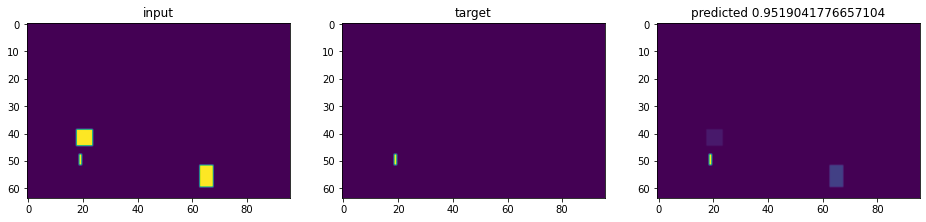

In [3]:

b, nc, h, w = 10, 1, 64, 96
model = DifferentialMaxtree(num_channels=1)
model.initialize()
optimizer = torch.optim.Adam(model.parameters(), 0.001)

def small_area(xmin, ymin, xmax, ymax):
    area = (xmax-xmin) * (ymax - ymin)
    return area < 25

for epoch in range(50):

    for i in range(100):
        x, y = small_recs(b, 1, h, w, num_rect=5, max_size=10, criteria_fun=small_area)
        optimizer.zero_grad()
        filtered = model(x)
        loss = torch.nn.MSELoss()(filtered, y)
        loss.backward()
        optimizer.step()


    subplot(1,3,1)
    imshow(x[0,0].numpy())
    title('input')

    subplot(1,3,2)
    imshow(y[0,0].numpy())
    title('target')

    subplot(1,3,3)
    imshow(filtered[0,0].detach().numpy())
    title(f'predicted {filtered[0,0].detach().numpy().max()}')

    show()
    display.clear_output(wait=True)




### Train a DifferentialMaxtree to filter horizontal rectangles

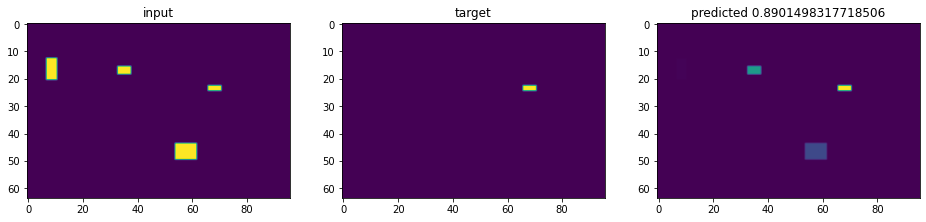

In [7]:
b, nc, h, w = 10, 1, 64, 96
model = DifferentialMaxtree(num_channels=1)
model.initialize()
optimizer = torch.optim.Adam(model.parameters(), 0.001)

def horizontal_rect(xmin, ymin, xmax, ymax):
    ratio = (xmax-xmin) / (ymax - ymin + 1)
    return ratio > 1.25

for epoch in range(50):

    for i in range(100):
        x, y = small_recs(b, 1, h, w, num_rect=5, max_size=10, criteria_fun=horizontal_rect)
        optimizer.zero_grad()
        filtered = model(x)
        loss = torch.nn.MSELoss()(filtered, y)
        loss.backward()
        optimizer.step()


    subplot(1,3,1)
    imshow(x[0,0].numpy())
    title('input')

    subplot(1,3,2)
    imshow(y[0,0].numpy())
    title('target')

    subplot(1,3,3)
    imshow(filtered[0,0].detach().numpy())
    title(f'predicted {filtered[0,0].detach().numpy().max()}')

    show()
    display.clear_output(wait=True)

### Train to filter rectangle in an area range

In [28]:

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.nb_channels = 2
        self.diff_maxtree = DifferentialMaxtree(num_channels= self.nb_channels)
        
    def forward(self, inputt):
        inputt_stacked = torch.cat([inputt]*self.nb_channels, dim = 1)
        filtered_output = self.diff_maxtree(inputt_stacked)
        return filtered_output.min(dim=1, keepdim=True)[0]
    
    def initialize(self):
        self.diff_maxtree.initialize()
    

model = Model()
model.initialize()
optimizer = torch.optim.Adam(model.parameters(), 0.001)

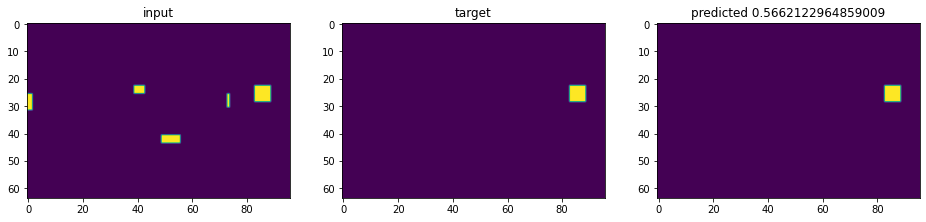

In [29]:
def area_range(xmin, ymin, xmax, ymax):
    area = (xmax-xmin) * (ymax - ymin )
    return 25 < area and area < 50

for epoch in range(50):

    for i in range(100):
        x, y = small_recs(b, 1, h, w, num_rect=5, max_size=10, criteria_fun=area_range)
        optimizer.zero_grad()
        filtered = model(x)
        loss = torch.nn.MSELoss()(filtered, y)
        loss.backward()
        optimizer.step()


    subplot(1,3,1)
    imshow(x[0,0].numpy())
    title('input')

    subplot(1,3,2)
    imshow(y[0,0].numpy())
    title('target')

    subplot(1,3,3)
    imshow(filtered[0,0].detach().numpy() > .5)
    title(f'predicted {filtered[0,0].detach().numpy().max()}')

    show()
    display.clear_output(wait=True)

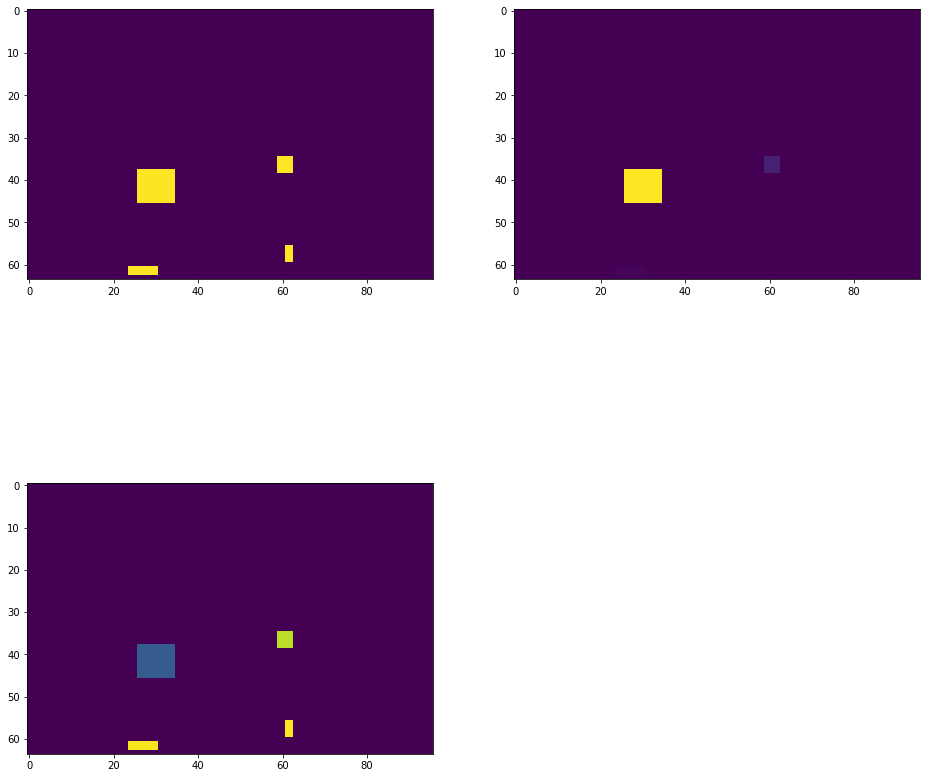

In [27]:
inputt_stacked = torch.cat([x]*model.nb_channels, dim = 1)
filtered_output = model.diff_maxtree(inputt_stacked)

subplot(1,2,1)
imshow(filtered_output[0,0].detach().numpy())

subplot(1,2,2)
imshow(filtered_output[0,1].detach().numpy())
